In [ ]:
import fastcore.all as fc

In [ ]:
url = 'https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz'

In [ ]:
from pathlib import Path
import pickle,gzip, math,os,time,shutil,matplotlib as mpl,matplotlib.pyplot as plt
from glob import glob
from torch import tensor

from miniai.datasets import *

In [ ]:
path = Path('data/camvid')

In [ ]:
if not path.exists():
    path_tgz = fc.urlsave(url, 'data')
    shutil.unpack_archive(str(path_tgz), 'data')

In [ ]:
path.ls()

(#4) [Path('data/camvid/labels'),Path('data/camvid/codes.txt'),Path('data/camvid/images'),Path('data/camvid/valid.txt')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
fnames = glob(str(path_img/'*.png'))
lbl_names = glob(str(path_lbl/'*.png'))

In [ ]:
img_f = Path(fnames[0])

In [ ]:
img_f

Path('data/camvid/images/0001TP_007050.png')

In [ ]:
from torchvision.io import read_image

In [ ]:
img = read_image(str(img_f))/255
img.shape

torch.Size([3, 720, 960])

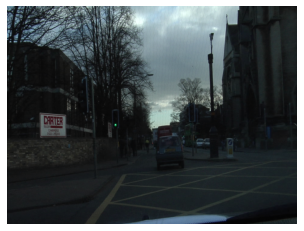

In [ ]:
show_image(img);

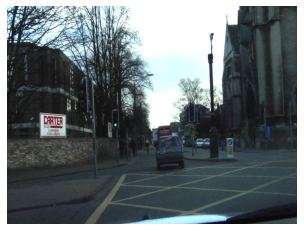

In [ ]:
show_image((img*2).clamp_max(1));

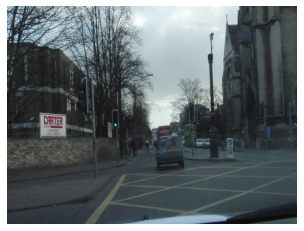

In [ ]:
show_image((img.clamp(0.001,0.999).logit()+1).sigmoid());

In [ ]:
def get_y_fn(x): return path_lbl/f'{x.stem}_P{x.suffix}'

In [ ]:
mask_f = get_y_fn(img_f)

In [ ]:
mask = read_image(str(mask_f))
mask.shape

torch.Size([1, 720, 960])

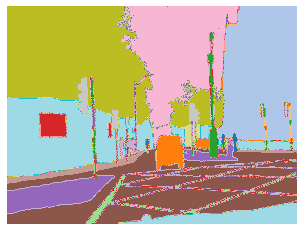

In [ ]:
show_image(mask, cmap='tab20');

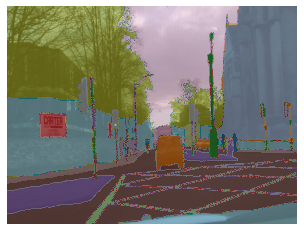

In [ ]:
ax = show_image(img)
show_image(mask, ax=ax, cmap='tab20', alpha=0.5);

In [ ]:
codes = (path/'codes.txt').read_text().splitlines(False)
' '.join(codes)

'Animal Archway Bicyclist Bridge Building Car CartLuggagePram Child Column_Pole Fence LaneMkgsDriv LaneMkgsNonDriv Misc_Text MotorcycleScooter OtherMoving ParkingBlock Pedestrian Road RoadShoulder Sidewalk SignSymbol Sky SUVPickupTruck TrafficCone TrafficLight Train Tree Truck_Bus Tunnel VegetationMisc Void Wall'

In [ ]:
codes[26]

'Tree'

In [ ]:
src_size = tensor(mask.shape[1:])

In [ ]:
valids = set((path/'valid.txt').read_text().splitlines(False))
list(valids)[:5]

['0016E5_07967.png',
 '0016E5_08159.png',
 '0016E5_08097.png',
 '0016E5_08107.png',
 '0016E5_08025.png']

In [ ]:
img = read_image(str(img_f))
img.shape

torch.Size([3, 720, 960])

In [ ]:
from fastai.vision.all import *

In [ ]:
bs = 8

In [ ]:
dblock = DataBlock(blocks=(ImageBlock(), MaskBlock(codes=codes)),
                   splitter=FuncSplitter(lambda o: o.name in valids),
                   get_y=get_y_fn,
                   item_tfms=Resize((720//4,960//4)))

In [ ]:
img_files = get_image_files(path/"images")

In [ ]:
dls = dblock.dataloaders(img_files, path=path, num_workers=4)

In [ ]:
xb,yb = next(iter(dls.train))

In [ ]:
xb.shape

torch.Size([64, 3, 180, 240])

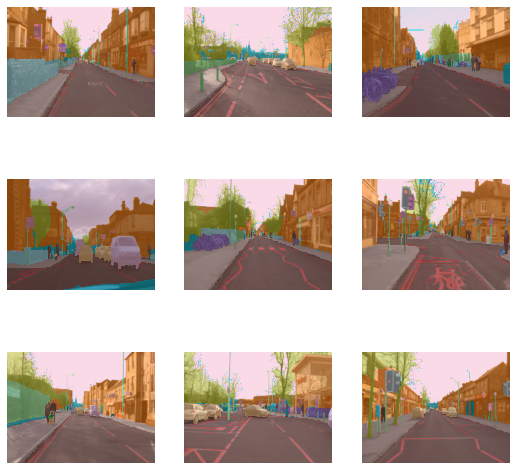

In [ ]:
dls.show_batch()

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [ ]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
learn = unet_learner(dls, resnet18, metrics=acc_camvid, pretrained=False)
learn.fit_one_cycle(8)

/home/jhoward/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jhoward/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc_camvid,time
0,2.763309,2.013649,0.562437,00:08
1,2.207503,3.337129,0.490906,00:08
2,1.851820,1.521761,0.524140,00:08
3,1.605628,1.273643,0.619193,00:08
4,1.426181,1.077186,0.692194,00:08
5,1.283914,0.972155,0.711177,00:08
6,1.173547,0.891734,0.744140,00:08
7,1.090320,0.830301,0.770479,00:08


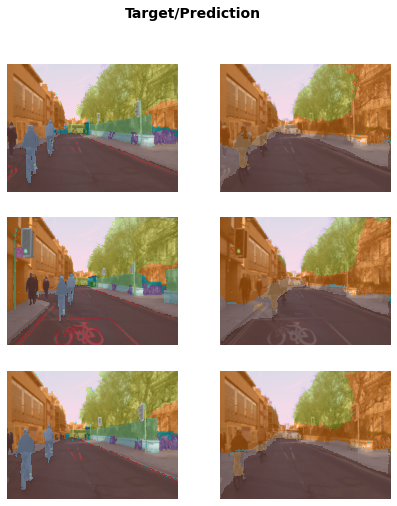

In [ ]:
learn.show_results(max_n=3, figsize=(7,8))

In [ ]:
learn = unet_learner(dls, resnet18, metrics=acc_camvid)
learn.fine_tune(8)

/home/jhoward/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc_camvid,time
0,3.036344,2.613300,0.332730,00:08


epoch,train_loss,valid_loss,acc_camvid,time
0,2.154839,2.061621,0.512869,00:08
1,1.883632,1.393234,0.607399,00:08
2,1.634063,1.208621,0.631365,00:08
3,1.418357,0.825777,0.789973,00:08
4,1.238171,0.706398,0.827337,00:08
5,1.100240,0.642927,0.835478,00:08
6,0.994110,0.622192,0.835631,00:08
7,0.913408,0.620253,0.835496,00:08


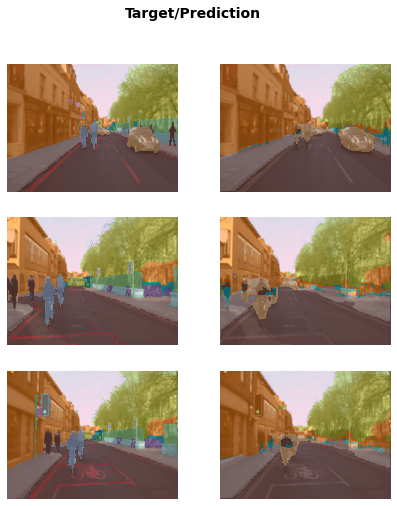

In [ ]:
learn.show_results(max_n=3, figsize=(7,8))